# Handwritten Digits Recognition Classification Using Convolutional Neural Network

**Objective**

This project aims to classify hand written digits into 10 categories ranging from 0 to 9.

**Method**


1. Install the necessary python packages.  For this model, we utilized pytorch to implement the neural network.

2. Data was imported and examined.  Analysis was conducted to understand the features and classes.  We reconstructed the original image to gain a visual understanding of the data.  Overall, the data was balanced among all classes and there were no missing values.

3. We normalized the dataset to ensure that all features have a standard scale. Since training in a neural network can be time-consuming, normalization can also help to speed up the training process.

4. Since we are going to be performing K-Fold cross validation, we define reusable functions to configure and evaluate the model.  This makes the training code much more readable.

5. Since we are using pytorch, we converted the data into pytorch tensors.

6. The model training begins across N folds.  During each iteration, the data in that fold is trained and evaluated.

7. The evaluation metrics were analyzed to ensure the model is performing correctly, averaging over a 96% accuracy each time and similar performance on F1 and Precision scores.  A confusion matrix was also implemented to further analyze the results of the model’s performance.


**Dependencies - Install**

In [ ]:
print("Begin Install Dependencies")
!pip install -q torch
!pip install -q torchvision
!pip install -q torchmetrics
!pip install -q numpy
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q ucimlrepo

print("End Install Dependencies")

Begin Install Dependencies
End Install Dependencies


**Dependencies - Import**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import torchmetrics
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold

**Dataloading**

The dataset consist of 5620, samples.

In [ ]:
writing = fetch_ucirepo(id=80)

**Analysis**

Here we can see each class between 0-9 has a fairly equal number of sample, this means it is not necessary to perform any balancing on the dataset.

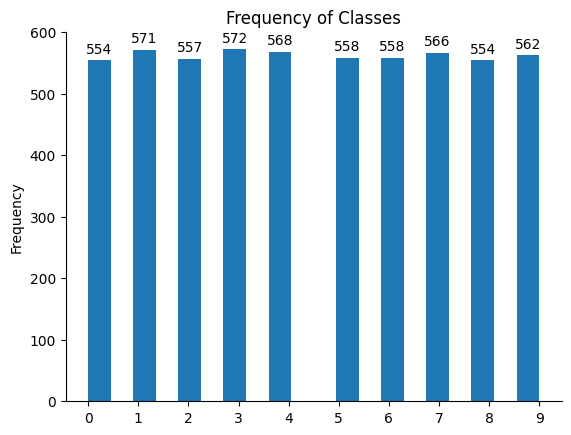

In [ ]:
ax = writing.data.targets['class'].plot(kind='hist', bins=20)

# Show all values on the x-axis
plt.xticks(range(int(writing.data.targets ['class'].min()), int(writing.data.targets ['class'].max()) + 1))

# Remove top and right bars
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Draw
for rect in ax.patches:
    height = rect.get_height()
    # There are 20 bins but we are only outputting 10 values so the other cells work as a
    # pad, otherwise matplot smashes them together, only annotate if there is a height
    if height>0:
      ax.annotate(f'{height:.0f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.title('Frequency of Classes')
plt.show()

**Analysis**

Each sample contains 64 features.

Each feature value ranges from 0 to 16 which represents the sum of positive pixels for each block in the original image.

In [ ]:
X = writing.data.features
y = writing.data.targets
X.head(10)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0
5,0,0,11,16,10,1,0,0,0,4,...,8,3,0,0,10,16,16,16,16,6
6,0,0,1,11,13,11,7,0,0,0,...,0,0,0,0,1,13,5,0,0,0
7,0,0,8,10,8,7,2,0,0,1,...,0,0,0,0,4,13,8,0,0,0
8,0,0,15,2,14,13,2,0,0,0,...,0,0,0,0,10,12,5,0,0,0
9,0,0,3,13,13,2,0,0,0,6,...,12,0,0,0,3,15,11,6,0,0


The 64 features can be represented as an 8x8 square matrix.

[[ 0  1  6 15 12  1  0  0]
 [ 0  7 16  6  6 10  0  0]
 [ 0  8 16  2  0 11  2  0]
 [ 0  5 16  3  0  5  7  0]
 [ 0  7 13  3  0  8  7  0]
 [ 0  4 12  0  1 13  5  0]
 [ 0  0 14  9 15  9  0  0]
 [ 0  0  6 14  7  1  0  0]]

 Showing image for the first sample that has been classified as 0


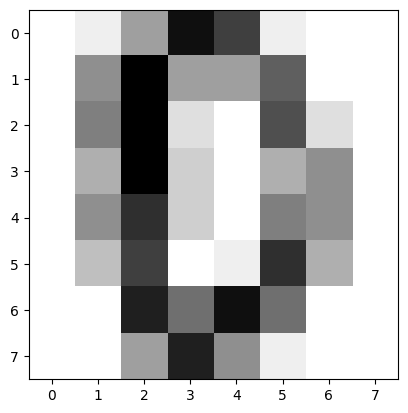

In [ ]:
X_reshaped = X.values[:10].reshape(-1, 8, 8)

print(X_reshaped[0])
print("\n Showing image for the first sample that has been classified as 0")

plt.imshow(X_reshaped[0], cmap='gray_r')
plt.show()

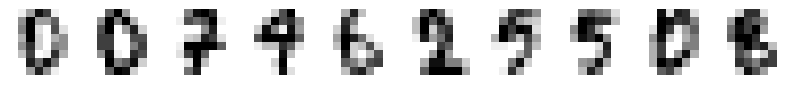

In [ ]:
ig, axes = plt.subplots(1, 10 , figsize = (10,1.5))

for i, ax in enumerate(axes):
    ax.imshow(X_reshaped[i], cmap='gray_r')
    ax.axis('off')

plt.show()

**Normalize features**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Normalized Sample")
X_scaled[0]

Normalized Sample


array([ 0.        ,  0.79313327,  0.12986348,  0.74831744,  0.09450787,
       -0.81585144, -0.41097194, -0.13206188, -0.03542401,  1.62296632,
        1.00999062, -1.44911936, -0.94280989,  0.29178646, -0.53252006,
       -0.1466391 , -0.04069176,  1.5466172 ,  1.08427078, -0.8190465 ,
       -1.16349493,  0.48375442,  0.01042016, -0.11335335, -0.03269184,
        0.84415735,  1.10740032, -1.02318838, -1.56286359, -0.46403448,
        1.2807267 , -0.04777844, -0.02984078,  1.47241212,  0.85010099,
       -0.99520444, -1.74442775, -0.17931693,  1.16744553,  0.        ,
       -0.07872062,  0.86007938,  0.82966502, -1.11476112, -1.08631271,
        0.77341948,  0.34592509, -0.08987191, -0.0576035 , -0.40589805,
        1.10346414, -0.1498682 ,  1.0064432 , -0.019331  , -0.76183046,
       -0.19789895, -0.01886792, -0.30310217,  0.04770289,  0.46244502,
       -0.9190364 , -0.98379588, -0.51724355, -0.1791362 ])

**CNN Configurations**

Define the model with options defined in the specification see comments for specifics on each point. Additional detail on several points

MaxPooling:

We use a 2x2 matrix so that it looks at each chunk of 2x2 pixels and moves 2 pixels at a time for downsampling

We fully connect the layers and apply a soft max function as well, see comments for other functions applied.



In [ ]:
def configure_model():
  model = nn.Sequential(
      # Layer one of the model with 1 in channel and 32 outputs for layer 2 and defines
      # The kernel as a 3x3 matrix
      nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
      # The activation function as required by the writeup
      nn.ReLU(),

      # Start layer 2, 32 inputs, 64 outputs same kernel size
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      # Same activation
      nn.ReLU(),

      # start layer 3 starting with max pooling
      nn.MaxPool2d(2, 2),
      # Dropout to try to prevent overfitting
      nn.Dropout(0.5),
      # Flatten from 2 d to 1 d
      nn.Flatten(),
      # Fully contected, taking in 1024 inputs and outputting 128
      nn.Linear(1024, 128),
      nn.ReLU(),
      # Drop it out again to fight overfitting
      nn.Dropout(0.5),
      # Reducing to 10 out features
      nn.Linear(128, 10),
      # Softmax as required in the writeup
      nn.LogSoftmax(dim=1)
  )

  return model


Weight initialization for model, ensuring that convolutional layers are initialized with Kaiming uniform and linear layers

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

**evaluate_model** will return an array of loss, correct prediction, test dataset size and confusion matrix for each fold


In [ ]:
def evaluate_model(model):
  model.eval()
  test_loss = 0
  correct = 0
  confusion_matrix = None
  loss_curve = []
  matrix = torchmetrics.ConfusionMatrix(task="multiclass",num_classes=10)
  with torch.no_grad():
      for data, target in testloader:
          output = model(data)
          # Convert logits to probabilities
          probabilities = F.softmax(output, dim=1)
          test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
          loss_curve.append(loss.item())
          pred = output.argmax(dim=1, keepdim=False)
          correct += pred.eq(target).sum().item()
          # Update confusion matrix with probabilities or class indices
          matrix.update(pred, target)
      confusion_matrix = matrix.compute()
      test_loss /= len(testloader.dataset)

  return [test_loss, correct, len(testloader.dataset), confusion_matrix, loss_curve]

In [ ]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_ravel = y.values.ravel()
y_tensor = torch.tensor(y_ravel, dtype=torch.int64)


**Training the Model**

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=30)

learning_rates = []

# sum the data returned by each fold
total = {
    "loss" : 0,
    "correct" : 0,
    "dataset":0,
    "confusion_matrix": 0*64,
    "loss_curve_data": []

}

for fold, (train_index, test_index) in enumerate(kf.split(X_tensor)):

    # Split the data into training and test sets for this fold
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

    # Reshape the data
    X_train = X_train.view(-1, 1, 8, 8)
    X_test = X_test.view(-1, 1, 8, 8)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # DataLoader
    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = configure_model()
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

    model.train()
    loss_curve_epochs=list()
    # Train the model over 10 epochs
    for epoch in range(10):
        lossForAllBatch = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.nll_loss(output, target)
            loss.backward()
            lossForAllBatch+=loss.item()
            optimizer.step()
        scheduler.step()
        loss_curve_epochs.append(lossForAllBatch/len(trainloader))
    # Append the learning rate for this fold
    learning_rates.append(scheduler.get_last_lr()[0])

    # store the results
    result = evaluate_model(model)
    total["loss"] += result[0]
    total["correct"]  += result[1]
    total["dataset"]  += result[2]
    total["confusion_matrix"] +=  result[3]
    total["loss_curve_data"].append(loss_curve_epochs)

**Overall Performance of the Model**

In [ ]:
precision = torch.diag(total["confusion_matrix"]) / total["confusion_matrix"].sum(axis=0)
f1_score = 2 * torch.diag(total["confusion_matrix"]) / (total["confusion_matrix"].sum(axis=0) + total["confusion_matrix"].sum(axis=1))

print(f"Dataset Correct : {total['correct']}")
print(f"Dataset loss : {total['loss']}")
print(f"Total Dataset : {total['dataset']}")
print(f"Accuracy : {(total['correct']/total['dataset']) * 100:.2f} %")
print(f"Precision: {precision.mean()* 100:.2f} %")
print(f"F1: {f1_score.mean()* 100:.2f} %")


Dataset Correct : 5523
Dataset loss : 0.2525857490152651
Total Dataset : 5620
Accuracy : 98.27 %
Precision: 98.29 %
F1: 98.28 %


**Consfusion Matrix**


In addition to high accuracy, confusion matrix shows the major of the samples were correctly classified.

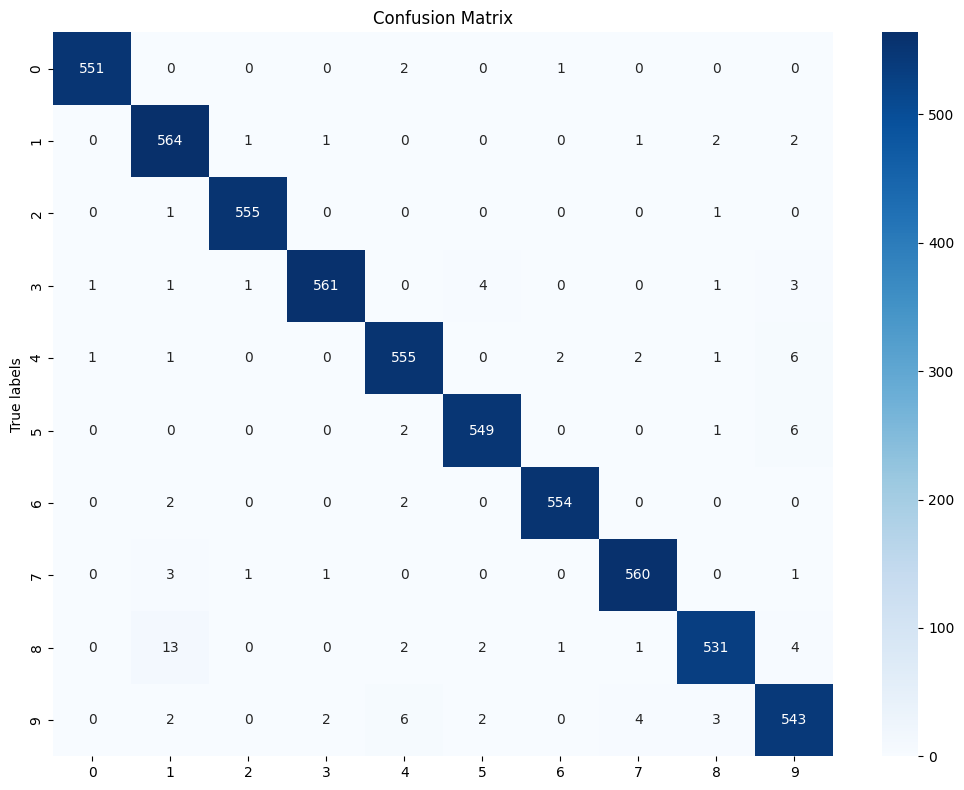

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(total["confusion_matrix"].numpy(), annot=True, fmt='g', cmap='Blues')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**Loss Curve**

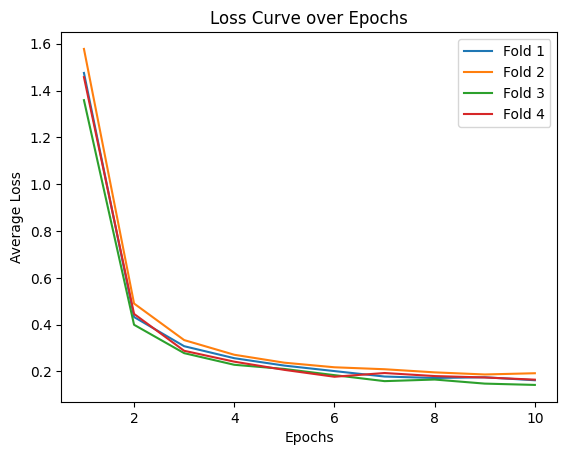

In [ ]:
# Plotting the loss curve for each fold
for i, losses in enumerate(total["loss_curve_data"]):
    plt.plot(range(1, len(losses) + 1), losses, label=f'Fold {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.show()